In [2]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models

/Users/treycole/Codes/WanPy/dev notebooks


In [3]:
# tight-binding parameters
delta = 1

# # checkerboard
# t0 = 0.4
# tprime = 0.5

# Haldane
t = 1
t2 = -0.3

n_super_cell = 1
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

In [41]:
def vel(model, klist):
    '''
    Computes the derivative of H_k at a set of given k-points.
    The output derivatives are wrt Cartesian coordinates (kx,ky).
    
    :param model: the TB model.
    :param klist: list of k-points at which the derivative is evaluated.
    The input list is in reduced coordinates (k1,k2).
    '''
    dim_k = model._dim_k
    kpnts = len(klist)
    n_orb = model.get_num_orbitals()
    hoppings = model._hoppings

    # Initialize velocity matrices corresponding to the k1 and k2 derivatives of H_k
    velred_x = np.zeros((kpnts, n_orb, n_orb), dtype=complex)
    velred_y = np.zeros((kpnts, n_orb, n_orb), dtype=complex)

    # Initialize array of lattice vectors to compute the B array
    a1 = model._lat[0]
    a2 = model._lat[1]
    A = np.zeros((dim_k, dim_k))
    A[0] = a1[0: dim_k]
    A[1] = a2[0:dim_k]
    A = A/(2*np.pi)

    # B array enables chain rule to go from (k1, k2) to (kx, ky)
    B = np.transpose(A) # Used later for chain rule

    for m in range(kpnts):
        for hopping in hoppings:
            #See _gen_ham function
            kpnt = klist[m]
            amp = complex(hopping[0])

            i = hopping[1]
            j = hopping[2]

            ind_R = np.array(hopping[3], dtype=float)

            rv = -model._orb[i, :] + model._orb[j, :] + ind_R
            rv = rv[model._per]

            phase = np.exp((2.0j) * np.pi * np.dot(kpnt, rv))

            amp_x = 2j * np.pi * rv[0] * amp * phase # Derivative of H_k wrt k1
            amp_y = 2j * np.pi * rv[1] * amp * phase # Derivative of H_k wrt k2
            # print(f"{i}, {j}, k = {kpnt}, ampx = {amp_x}, ampy = {amp_y}")

            velred_x[m, i, j] += amp_x
            velred_x[m, j, i] += amp_x.conjugate()
            velred_y[m, i, j] += amp_y
            velred_y[m, j, i] += amp_y.conjugate()

    #Apply chain rule to obtain velocity matrix in Cartesian basis
    vel_x = B[0][0] * velred_x + B[0][1] * velred_y
    vel_y = B[1][0] * velred_x + B[1][1] * velred_y

    vel = np.concatenate((vel_x[:, np.newaxis, ...], vel_y[:, np.newaxis, ...]), axis=1)

    return vel

In [40]:
k_mesh = K_mesh(model, 10, 10)
full_mesh = k_mesh.gen_k_mesh(endpoint=True)

v_k_arr = model.gen_velocity(full_mesh)
v_k_arr_Dan = vel(model, full_mesh)
np.allclose(v_k_arr_Dan, v_k_arr)

True

In [6]:
def quantum_geom_tens(model, k_vec):
    dim_k = k_vec.shape[-1]
    Nk = k_vec.shape[0]
    
    evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
    n_eigs = evecs.shape[1]

    v_k = gen_velocity(model, k_vec)
    v_k_rot = np.einsum("...ni, ...aij, ...mj -> ...anm", evecs.conj(), v_k, evecs)  # (n_kpts, dim_k, n_orb, n_orb)
    delta_E = evals[..., np.newaxis, :] - evals[..., :, np.newaxis]
    delta_E_sq = delta_E**2
    QGT = np.zeros((Nk, n_eigs, dim_k, dim_k), dtype=complex)

    for n in range(n_eigs):
        for m in range(n_eigs):
            if n != m:
                for mu in range(dim_k):
                    v_nm_mu = v_k_rot[:, mu, n, m]
                    for nu in range(dim_k):
                        v_mn_nu = v_k_rot[:, nu, m, n]
                        QGT[:, n, mu, nu] += (v_nm_mu * v_mn_nu) / delta_E_sq[:, n, m]

    return QGT

In [7]:
# wf = wf_array(model, [20, 20])
# wf.solve_on_grid([0,0])

# evals, evecs = model.solve_ham(full_mesh, return_eigvecs=True)

In [10]:
# %load_ext line_profiler
# %lprun -f model.solve_ham model.solve_ham(full_mesh, return_eigvecs=True)

In [28]:
nkx, nky = 100, 100
k_mesh = K_mesh(model, nkx, nky)
full_mesh = k_mesh.gen_k_mesh(endpoint=False)

QGT = model.quantum_geom_tens(full_mesh)
Omega = -2 * QGT.imag[..., 0, 1] 
g = QGT.real[..., 0, 1]

V_BZ = model.get_recip_vol()
dk_sq = V_BZ / (nkx * nky)
Chern = np.sum(Omega, axis=0) * dk_sq / (2 * np.pi)

u_wfs_full = wf_array(model, [100, 100])
u_wfs_full.solve_on_grid([0, 0])
Chern_2 = u_wfs_full.berry_flux([0])/(2*np.pi)

In [14]:
# %load_ext line_profiler
# %lprun -f model.quantum_geom_tens model.quantum_geom_tens(full_mesh)

In [15]:
Chern_2

np.float64(0.9999999999999999)

In [16]:
Chern

array([ 1., -1.])

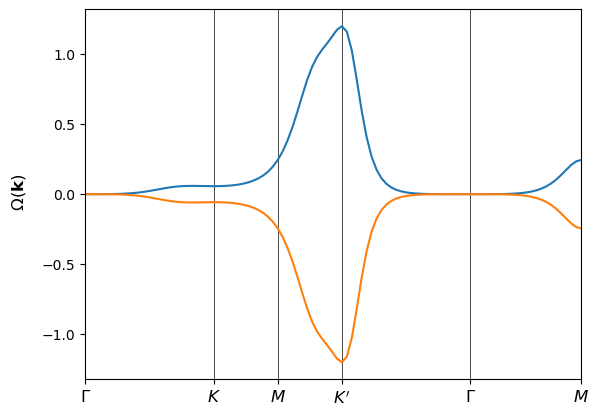

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

QGT = model.quantum_geom_tens(k_vec)
Omega_path = -2 * QGT.imag[..., 0, 1]
g_path = QGT.real[..., 0, 1]

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $\Omega(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

for n in range(Omega_path.shape[-1]):
    plt.plot(k_dist, Omega_path[:, n] )

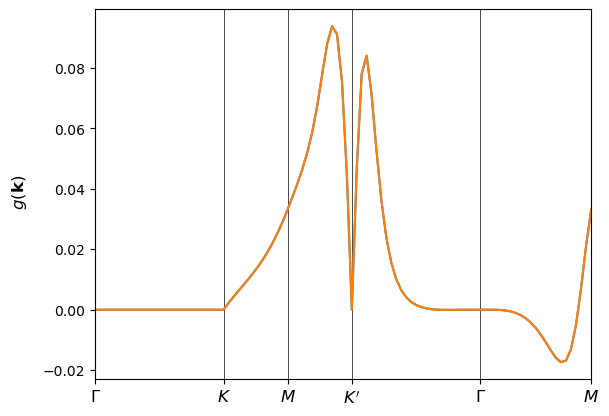

In [30]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $g(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

for n in range(g_path.shape[-1]):
    plt.plot(k_dist, g_path[:, n] )

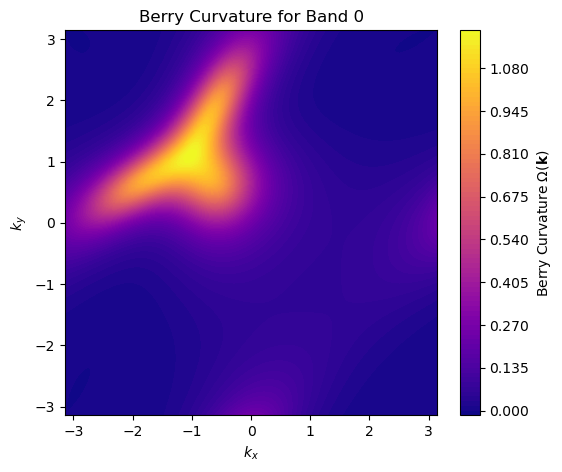

In [31]:
# Reshape Omega for plotting
band_idx = 0
Omega_band = Omega[:, band_idx].reshape(nkx, nky)

# Generate k-grid for plotting
kx_vals = np.linspace(-np.pi, np.pi, nkx)
ky_vals = np.linspace(-np.pi, np.pi, nky)
KX, KY = np.meshgrid(kx_vals, ky_vals)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, Omega_band.T, levels=100, cmap='plasma')
plt.colorbar(label=r'Berry Curvature $\Omega(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Berry Curvature for Band {band_idx}')
plt.show()

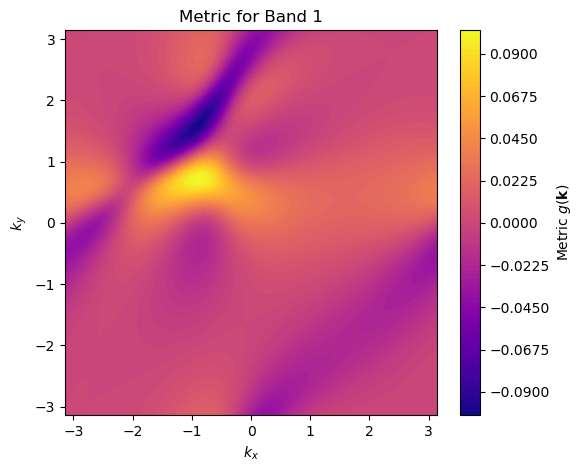

In [39]:
# Reshape Omega for plotting
band_idx = 1
g_band = g[:, band_idx].reshape(nkx, nky)

# Generate k-grid for plotting
kx_vals = np.linspace(-np.pi, np.pi, nkx)
ky_vals = np.linspace(-np.pi, np.pi, nky)
KX, KY = np.meshgrid(kx_vals, ky_vals)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, g_band.T, levels=100, cmap='plasma')
plt.colorbar(label=r'Metric $g(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Metric for Band {band_idx}')
plt.show()

In [ ]:
QGT = model.quantum_geom_tens(k_vec) # shape: (k, band, dim r, dim r)
Omega_path = -2 * QGT.imag
g_path = QGT.real

omega_I = np.trace(g_path, axis1=2, axis2=3)
Omega_path.shape

In [ ]:
# QGT_rot = interp_unk_til.conj() @ QGT @ np.transpose(interp_unk_til,  axes=(0,2,1))

In [ ]:
model.Chern_num()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $\Omega(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

for n in range(n_orb):
    ax.plot(k_dist, Omega_path[:, n, 0, 1], label=f'Berry curvature of band {n}' )

# idx = 4
# ax.plot(k_dist, Omega_path[:, idx, 0, 1], label=f'Berry curvature of band {idx}' )

ax.legend()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.yaxis.labelpad = 10

for n in range(1):
    plt.plot(k_dist, g_path[:, n, 0, 1], c='b', label=r'$g_{x,y}$' )
    plt.plot(k_dist, g_path[:, n, 0, 0], c='g', label=r'$g_{x,x}$')
    plt.plot(k_dist, g_path[:, n, 1, 1], c='orange', label=r'$g_{y,y}$' )

ax.legend()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(k_dist, omega_I[:, 0])

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $\omega_I(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

In [ ]:
nkx, nky = 20, 20
k_mesh = K_mesh(model, nkx, nky)
full_mesh = k_mesh.gen_k_mesh(endpoint=False)
full_mesh_mat = k_mesh.gen_k_mesh(flat=False, endpoint=False)
recip_lat_vecs = model.get_recip_lat_vecs()
mesh_Cart = full_mesh_mat @ recip_lat_vecs

KX = mesh_Cart[:, :, 0]
KY = mesh_Cart[:, :, 1]

QGT = model.quantum_geom_tens(full_mesh)
Omega = -2 * QGT.imag 
g = QGT.real

In [ ]:
# Reshape Omega for plotting
band_idx = 0
Omega_band = Omega[:, band_idx, 0, 1].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.contourf(KX, KY, Omega_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Berry Curvature for Band {band_idx}')
# plt.gca().set_aspect('equal')
plt.show()

In [ ]:
# Reshape Omega for plotting
band_idx = 0
gxx_band = g[:, band_idx, 0, 0].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.contourf(KX, KY, gxx_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$g_{xx}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric xx for Band {band_idx}')
plt.show()

In [ ]:
# Reshape Omega for plotting
band_idx = 0
gyy_band = g[:, band_idx, 1, 1].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, gyy_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$g_{yy}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric yy for Band {band_idx}')
plt.show()

In [ ]:
# Reshape Omega for plotting
band_idx = 1
gxy_band = g[:, band_idx, 0, 1].reshape(nkx, nky)

# Generate k-grid for plotting
kx_vals = np.linspace(0, 1, nkx)
ky_vals = np.linspace(0, 1, nky)
# KX, KY = np.meshgrid(kx_vals, ky_vals)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, gxy_band, levels=100, cmap='bwr')
plt.colorbar(label=r'$g_{xy}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric xy for Band {band_idx}')
plt.show()